In [1]:
import os
print(os.getcwd())

/content


In [3]:
import pandas as pd
df=pd.read_csv("google-data.csv",parse_dates=["Date"])

In [4]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
df.duplicated().sum()

0

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1259 non-null   datetime64[ns]
 1   Open       1259 non-null   float64       
 2   High       1259 non-null   float64       
 3   Low        1259 non-null   float64       
 4   Close      1259 non-null   float64       
 5   Adj Close  1259 non-null   float64       
 6   Volume     1259 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 69.0 KB


In [7]:
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,357.385559,361.151062,355.959839,359.288177,359.288177,5115500
1,2013-01-03,360.122742,363.600128,358.031342,359.496826,359.496826,4666500
2,2013-01-04,362.313507,368.339294,361.488861,366.600616,366.600616,5562800
3,2013-01-07,365.348755,367.301056,362.929504,365.001007,365.001007,3332900
4,2013-01-08,365.393463,365.771027,359.874359,364.280701,364.280701,3373900


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

In [9]:
data=pd.DataFrame()
data['Date']=pd.date_range(start=df.iloc[0,0],end=df.iloc[-1,0])
data=pd.merge(data,df,on="Date",how="left")
data.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,357.385559,361.151062,355.959839,359.288177,359.288177,5115500.0
1,2013-01-03,360.122742,363.600128,358.031342,359.496826,359.496826,4666500.0
2,2013-01-04,362.313507,368.339294,361.488861,366.600616,366.600616,5562800.0
3,2013-01-05,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-06,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
data.shape

(1823, 7)

In [11]:
data.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,357.385559,361.151062,355.959839,359.288177,359.288177,5115500.0
1,2013-01-03,360.122742,363.600128,358.031342,359.496826,359.496826,4666500.0


In [12]:
cols=["Open","High","Low","Close","Adj Close","Volume"]
for col in cols:
  data[col]=data[col].interpolate(method="quadratic")

In [13]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,357.385559,361.151062,355.959839,359.288177,359.288177,5.115500e+06
1,2013-01-03,360.122742,363.600128,358.031342,359.496826,359.496826,4.666500e+06
2,2013-01-04,362.313507,368.339294,361.488861,366.600616,366.600616,5.562800e+06
3,2013-01-05,363.816296,370.300761,363.871814,369.476065,369.476065,5.418456e+06
4,2013-01-06,364.681025,369.078159,364.630744,367.160459,367.160459,4.115593e+06


<Axes: >

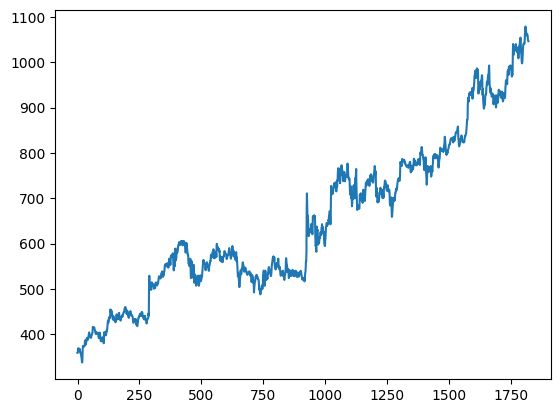

In [14]:
data['Close'].plot()

In [15]:
model_df=df[["Date","Close"]].rename(columns={"Date":"ds","Close":"y"})
model_df

,ds,y
0,2013-01-02,359.288177
1,2013-01-03,359.496826
2,2013-01-04,366.600616
3,2013-01-07,365.001007
4,2013-01-08,364.280701
...,...,...
1254,2017-12-22,1060.119995
1255,2017-12-26,1056.739990
1256,2017-12-27,1049.369995
1257,2017-12-28,1048.140015


In [16]:
from sklearn.model_selection import ParameterGrid
parameters={
    "changepoint_prior_scale":[0.1,0.2],
    "n_changepoints":[1,5],
    "holidays_prior_scale":[0.1,0.2],
    "seasonality_mode":["multiplicative","additive"],
    "yearly_seasonality":["auto",True,False]
}
parameter_grid=ParameterGrid(parameters)

parameter_list=[]
for p in parameter_grid:
  print(p)
  model=Prophet(changepoint_prior_scale=p["changepoint_prior_scale"],
                n_changepoints=p["n_changepoints"],
                holidays_prior_scale=p["holidays_prior_scale"],
                seasonality_mode=p["seasonality_mode"],
                yearly_seasonality=p["yearly_seasonality"],
                interval_width=0.95)
  model.fit(model_df)
  future=model.make_future_dataframe(periods=100,freq="D")
  forecast=model.predict(future)

  predicted=forecast[["ds","yhat"]]
  actual=model_df

  mpe=np.mean((predicted["yhat"]-actual["y"])/actual["y"])
  print("MPE:",mpe)
  parameter_list.append([mpe,p])





{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 'auto'}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/9rcjgsrl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/lbgsri85.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11860', 'data', 'file=/tmp/tmpq5iiwert/9rcjgsrl.json', 'init=/tmp/tmpq5iiwert/lbgsri85.json', 'output', 'file=/tmp/tmpq5iiwert/prophet_model7phn0m50/prophet_model-20231027152807.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:28:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5

MPE: 0.004894754867440821
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/bmxe5m6m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/a9ksqof6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2281', 'data', 'file=/tmp/tmpq5iiwert/bmxe5m6m.json', 'init=/tmp/tmpq5iiwert/a9ksqof6.json', 'output', 'file=/tmp/tmpq5iiwert/prophet_modell_at3k18/prophet_model-20231027152808.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:28:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MPE: 0.004894754867440821
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': False}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/a8g1wxug.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/bove7z6a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55759', 'data', 'file=/tmp/tmpq5iiwert/a8g1wxug.json', 'init=/tmp/tmpq5iiwert/bove7z6a.json', 'output', 'file=/tmp/tmpq5iiwert/prophet_model6r7_c3tg/prophet_model-20231027152808.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:28:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MPE: 0.005125751388051336
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 1, 'seasonality_mode': 'additive', 'yearly_seasonality': 'auto'}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/hofqvrky.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/2xe23ouy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77144', 'data', 'file=/tmp/tmpq5iiwert/hofqvrky.json', 'init=/tmp/tmpq5iiwert/2xe23ouy.json', 'output', 'file=/tmp/tmpq5iiwert/prophet_model3ukdyqhi/prophet_model-20231027152808.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:28:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MPE: 0.004762504186414823
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 1, 'seasonality_mode': 'additive', 'yearly_seasonality': True}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/xf_th5hv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/d__0d_3z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57401', 'data', 'file=/tmp/tmpq5iiwert/xf_th5hv.json', 'init=/tmp/tmpq5iiwert/d__0d_3z.json', 'output', 'file=/tmp/tmpq5iiwert/prophet_modelt072e5xz/prophet_model-20231027152809.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:28:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MPE: 0.004762504186414823
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 1, 'seasonality_mode': 'additive', 'yearly_seasonality': False}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/4emq5qm4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/u9_pl06h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42078', 'data', 'file=/tmp/tmpq5iiwert/4emq5qm4.json', 'init=/tmp/tmpq5iiwert/u9_pl06h.json', 'output', 'file=/tmp/tmpq5iiwert/prophet_modelvutexil8/prophet_model-20231027152809.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MPE: 0.005127663262737429
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 5, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 'auto'}


15:28:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/z1v50syy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/pvdy6_p_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13786', 'data', 'file=/tmp/tmpq5iiwert/z1v50syy.json', 'init=/tmp/tmpq5iiwert/pvdy6_p_.json', 'output', 'file=/tmp/tmpq5iiwert/prophet_modelhfy2snqi/prophet_model-20231027152810.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MPE: 0.0026242247668457285
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 5, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True}


15:28:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/3np25z7g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/1f3h66l3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18599', 'data', 'file=/tmp/tmpq5iiwert/3np25z7g.json', 'init=/tmp/tmpq5iiwert/1f3h66l3.json', 'output', 'file=/tmp/tmpq5iiwert/prophet_model769tdslt/prophet_model-20231027152810.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MPE: 0.0026242247668457285
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 5, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': False}


15:28:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/xmnwpu1l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/29sfxovk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35203', 'data', 'file=/tmp/tmpq5iiwert/xmnwpu1l.json', 'init=/tmp/tmpq5iiwert/29sfxovk.json', 'output', 'file=/tmp/tmpq5iiwert/prophet_model22tvg53h/prophet_model-20231027152811.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:28:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MPE: 0.002833168092465583
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 5, 'seasonality_mode': 'additive', 'yearly_seasonality': 'auto'}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/mw9v_hbj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/q4jxspto.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51144', 'data', 'file=/tmp/tmpq5iiwert/mw9v_hbj.json', 'init=/tmp/tmpq5iiwert/q4jxspto.json', 'output', 'file=/tmp/tmpq5iiwert/prophet_modellzgq0h80/prophet_model-20231027152811.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:28:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MPE: 0.0026022240293665424
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 5, 'seasonality_mode': 'additive', 'yearly_seasonality': True}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/mgp7owvi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/040ugo1o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39717', 'data', 'file=/tmp/tmpq5iiwert/mgp7owvi.json', 'init=/tmp/tmpq5iiwert/040ugo1o.json', 'output', 'file=/tmp/tmpq5iiwert/prophet_modelhwmwzz1z/prophet_model-20231027152812.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:28:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MPE: 0.0026022240293665424
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 5, 'seasonality_mode': 'additive', 'yearly_seasonality': False}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/tranypm3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/sqg6ylaf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36067', 'data', 'file=/tmp/tmpq5iiwert/tranypm3.json', 'init=/tmp/tmpq5iiwert/sqg6ylaf.json', 'output', 'file=/tmp/tmpq5iiwert/prophet_modelfvor1k2b/prophet_model-20231027152812.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:28:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MPE: 0.0029269424705245287
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 'auto'}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/r6m1_hbu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/2vyjppfl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14410', 'data', 'file=/tmp/tmpq5iiwert/r6m1_hbu.json', 'init=/tmp/tmpq5iiwert/2vyjppfl.json', 'output', 'file=/tmp/tmpq5iiwert/prophet_modelttslxii9/prophet_model-20231027152812.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:28:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MPE: 0.004894754867440821
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/u6rivv2w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/c_ci5kyp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68802', 'data', 'file=/tmp/tmpq5iiwert/u6rivv2w.json', 'init=/tmp/tmpq5iiwert/c_ci5kyp.json', 'output', 'file=/tmp/tmpq5iiwert/prophet_modelhqcz6t01/prophet_model-20231027152813.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:28:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MPE: 0.004894754867440821
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': False}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/vr38u543.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/uqj2ajjn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33905', 'data', 'file=/tmp/tmpq5iiwert/vr38u543.json', 'init=/tmp/tmpq5iiwert/uqj2ajjn.json', 'output', 'file=/tmp/tmpq5iiwert/prophet_modelgstay0rm/prophet_model-20231027152813.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:28:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MPE: 0.005125751388051336
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 1, 'seasonality_mode': 'additive', 'yearly_seasonality': 'auto'}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/nvbemkd0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/e4v40ihd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64835', 'data', 'file=/tmp/tmpq5iiwert/nvbemkd0.json', 'init=/tmp/tmpq5iiwert/e4v40ihd.json', 'output', 'file=/tmp/tmpq5iiwert/prophet_model7zt57p43/prophet_model-20231027152813.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:28:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MPE: 0.004762504186414823
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 1, 'seasonality_mode': 'additive', 'yearly_seasonality': True}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/7gy4103k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/9khv_chc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10337', 'data', 'file=/tmp/tmpq5iiwert/7gy4103k.json', 'init=/tmp/tmpq5iiwert/9khv_chc.json', 'output', 'file=/tmp/tmpq5iiwert/prophet_model0mhjuk0h/prophet_model-20231027152814.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:28:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MPE: 0.004762504186414823
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 1, 'seasonality_mode': 'additive', 'yearly_seasonality': False}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/m3iqn5qw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/3jc0yge8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30116', 'data', 'file=/tmp/tmpq5iiwert/m3iqn5qw.json', 'init=/tmp/tmpq5iiwert/3jc0yge8.json', 'output', 'file=/tmp/tmpq5iiwert/prophet_modeld4jp8wl4/prophet_model-20231027152814.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MPE: 0.005127663262737429
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 5, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 'auto'}


15:28:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/47ca5bft.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/25wuj72a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5190', 'data', 'file=/tmp/tmpq5iiwert/47ca5bft.json', 'init=/tmp/tmpq5iiwert/25wuj72a.json', 'output', 'file=/tmp/tmpq5iiwert/prophet_model5yk3w29f/prophet_model-20231027152815.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MPE: 0.0026242247668457285
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 5, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True}


15:28:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/xrrfqef3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/k8rvooyk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73406', 'data', 'file=/tmp/tmpq5iiwert/xrrfqef3.json', 'init=/tmp/tmpq5iiwert/k8rvooyk.json', 'output', 'file=/tmp/tmpq5iiwert/prophet_modelzbv32d0m/prophet_model-20231027152815.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:28:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MPE: 0.0026242247668457285
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 5, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': False}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/135t2bm3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/7spwnv5d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16418', 'data', 'file=/tmp/tmpq5iiwert/135t2bm3.json', 'init=/tmp/tmpq5iiwert/7spwnv5d.json', 'output', 'file=/tmp/tmpq5iiwert/prophet_modeljjog6p6l/prophet_model-20231027152815.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:28:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MPE: 0.002833168092465583
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 5, 'seasonality_mode': 'additive', 'yearly_seasonality': 'auto'}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/at0w5kzo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/h07sy97n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87299', 'data', 'file=/tmp/tmpq5iiwert/at0w5kzo.json', 'init=/tmp/tmpq5iiwert/h07sy97n.json', 'output', 'file=/tmp/tmpq5iiwert/prophet_modelgn9vaf3t/prophet_model-20231027152816.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:28:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MPE: 0.0026022240293665424
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 5, 'seasonality_mode': 'additive', 'yearly_seasonality': True}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/accqchbo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/zywkm04m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52984', 'data', 'file=/tmp/tmpq5iiwert/accqchbo.json', 'init=/tmp/tmpq5iiwert/zywkm04m.json', 'output', 'file=/tmp/tmpq5iiwert/prophet_modelx_w2ii71/prophet_model-20231027152816.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:28:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MPE: 0.0026022240293665424
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 5, 'seasonality_mode': 'additive', 'yearly_seasonality': False}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/wgy2vakz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/rh_0rfgp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25949', 'data', 'file=/tmp/tmpq5iiwert/wgy2vakz.json', 'init=/tmp/tmpq5iiwert/rh_0rfgp.json', 'output', 'file=/tmp/tmpq5iiwert/prophet_modelz5yw6f1f/prophet_model-20231027152817.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:28:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MPE: 0.0029269424705245287
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 'auto'}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/nojhk6rl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/hbgkmrqg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62179', 'data', 'file=/tmp/tmpq5iiwert/nojhk6rl.json', 'init=/tmp/tmpq5iiwert/hbgkmrqg.json', 'output', 'file=/tmp/tmpq5iiwert/prophet_modeltnq95fv7/prophet_model-20231027152817.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:28:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MPE: 0.0048967060529574264
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/fehxkrcj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/qrjv66io.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82619', 'data', 'file=/tmp/tmpq5iiwert/fehxkrcj.json', 'init=/tmp/tmpq5iiwert/qrjv66io.json', 'output', 'file=/tmp/tmpq5iiwert/prophet_model9netz1kl/prophet_model-20231027152817.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:28:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MPE: 0.0048967060529574264
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': False}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/ahm451et.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/jbyg1pcb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55213', 'data', 'file=/tmp/tmpq5iiwert/ahm451et.json', 'init=/tmp/tmpq5iiwert/jbyg1pcb.json', 'output', 'file=/tmp/tmpq5iiwert/prophet_modelgh8f953w/prophet_model-20231027152818.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:28:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MPE: 0.005127321575327382
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 1, 'seasonality_mode': 'additive', 'yearly_seasonality': 'auto'}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/n392jyb4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/_br2aijc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72587', 'data', 'file=/tmp/tmpq5iiwert/n392jyb4.json', 'init=/tmp/tmpq5iiwert/_br2aijc.json', 'output', 'file=/tmp/tmpq5iiwert/prophet_modeltxphmivb/prophet_model-20231027152818.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:28:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MPE: 0.0047660678114897935
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 1, 'seasonality_mode': 'additive', 'yearly_seasonality': True}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/tid4d9ug.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/pitnd3cq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33170', 'data', 'file=/tmp/tmpq5iiwert/tid4d9ug.json', 'init=/tmp/tmpq5iiwert/pitnd3cq.json', 'output', 'file=/tmp/tmpq5iiwert/prophet_modelhlft33bi/prophet_model-20231027152818.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:28:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MPE: 0.0047660678114897935
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 1, 'seasonality_mode': 'additive', 'yearly_seasonality': False}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/ctrdhm0f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/n5brz10n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94074', 'data', 'file=/tmp/tmpq5iiwert/ctrdhm0f.json', 'init=/tmp/tmpq5iiwert/n5brz10n.json', 'output', 'file=/tmp/tmpq5iiwert/prophet_modelrg21fn2a/prophet_model-20231027152819.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MPE: 0.005126147787089005
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 5, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 'auto'}


15:28:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/oxyqz264.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/_8gv3mp5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78019', 'data', 'file=/tmp/tmpq5iiwert/oxyqz264.json', 'init=/tmp/tmpq5iiwert/_8gv3mp5.json', 'output', 'file=/tmp/tmpq5iiwert/prophet_modelxyz7311a/prophet_model-20231027152819.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MPE: 0.0026159287324517143
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 5, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True}


15:28:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/4hu9v8y7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/u1spbxg5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11860', 'data', 'file=/tmp/tmpq5iiwert/4hu9v8y7.json', 'init=/tmp/tmpq5iiwert/u1spbxg5.json', 'output', 'file=/tmp/tmpq5iiwert/prophet_model2clnjhh0/prophet_model-20231027152820.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MPE: 0.0026159287324517143
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 5, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': False}


15:28:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/3d6ng6ao.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/frq7pkh1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90843', 'data', 'file=/tmp/tmpq5iiwert/3d6ng6ao.json', 'init=/tmp/tmpq5iiwert/frq7pkh1.json', 'output', 'file=/tmp/tmpq5iiwert/prophet_modelwknsrcwy/prophet_model-20231027152820.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:28:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MPE: 0.0028247592232798144
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 5, 'seasonality_mode': 'additive', 'yearly_seasonality': 'auto'}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/s_1toyjx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/rw6chvu1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71128', 'data', 'file=/tmp/tmpq5iiwert/s_1toyjx.json', 'init=/tmp/tmpq5iiwert/rw6chvu1.json', 'output', 'file=/tmp/tmpq5iiwert/prophet_model5dmx_kmo/prophet_model-20231027152821.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MPE: 0.00255497992692466
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 5, 'seasonality_mode': 'additive', 'yearly_seasonality': True}


15:28:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/15i3cf4j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/yd518mzh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90450', 'data', 'file=/tmp/tmpq5iiwert/15i3cf4j.json', 'init=/tmp/tmpq5iiwert/yd518mzh.json', 'output', 'file=/tmp/tmpq5iiwert/prophet_model8kqs5wao/prophet_model-20231027152821.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:28:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MPE: 0.00255497992692466
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 5, 'seasonality_mode': 'additive', 'yearly_seasonality': False}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/rse6m23a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/5dt6x1eq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64970', 'data', 'file=/tmp/tmpq5iiwert/rse6m23a.json', 'init=/tmp/tmpq5iiwert/5dt6x1eq.json', 'output', 'file=/tmp/tmpq5iiwert/prophet_modell1skbsqp/prophet_model-20231027152822.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MPE: 0.0028742506390900726
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 'auto'}


15:28:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/_8bfz0bq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/5q8zckfw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97278', 'data', 'file=/tmp/tmpq5iiwert/_8bfz0bq.json', 'init=/tmp/tmpq5iiwert/5q8zckfw.json', 'output', 'file=/tmp/tmpq5iiwert/prophet_modeliwk5px7k/prophet_model-20231027152822.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MPE: 0.0048967060529574264
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True}


15:28:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/i1wvynok.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/adbb48_4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12349', 'data', 'file=/tmp/tmpq5iiwert/i1wvynok.json', 'init=/tmp/tmpq5iiwert/adbb48_4.json', 'output', 'file=/tmp/tmpq5iiwert/prophet_modelzfdl904t/prophet_model-20231027152823.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:28:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MPE: 0.0048967060529574264
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': False}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/ciy2andl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/sfbg7yyk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24412', 'data', 'file=/tmp/tmpq5iiwert/ciy2andl.json', 'init=/tmp/tmpq5iiwert/sfbg7yyk.json', 'output', 'file=/tmp/tmpq5iiwert/prophet_model5v8n08g4/prophet_model-20231027152823.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:28:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MPE: 0.005127321575327382
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 1, 'seasonality_mode': 'additive', 'yearly_seasonality': 'auto'}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/_pbfzwx3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/3u74i0y1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15834', 'data', 'file=/tmp/tmpq5iiwert/_pbfzwx3.json', 'init=/tmp/tmpq5iiwert/3u74i0y1.json', 'output', 'file=/tmp/tmpq5iiwert/prophet_modeleol5c7rs/prophet_model-20231027152823.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:28:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MPE: 0.0047660678114897935
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 1, 'seasonality_mode': 'additive', 'yearly_seasonality': True}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/c0p0yoac.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/8ldqd62p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20669', 'data', 'file=/tmp/tmpq5iiwert/c0p0yoac.json', 'init=/tmp/tmpq5iiwert/8ldqd62p.json', 'output', 'file=/tmp/tmpq5iiwert/prophet_model6xzzrtbe/prophet_model-20231027152824.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:28:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MPE: 0.0047660678114897935
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 1, 'seasonality_mode': 'additive', 'yearly_seasonality': False}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/51n8xevw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/2uwo7pp_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54725', 'data', 'file=/tmp/tmpq5iiwert/51n8xevw.json', 'init=/tmp/tmpq5iiwert/2uwo7pp_.json', 'output', 'file=/tmp/tmpq5iiwert/prophet_modelo81sejf1/prophet_model-20231027152824.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MPE: 0.005126147787089005
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 5, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 'auto'}


15:28:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/50kddfp8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/gvc_7re7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7104', 'data', 'file=/tmp/tmpq5iiwert/50kddfp8.json', 'init=/tmp/tmpq5iiwert/gvc_7re7.json', 'output', 'file=/tmp/tmpq5iiwert/prophet_modelo6w3bp88/prophet_model-20231027152824.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MPE: 0.0026159287324517143
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 5, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True}


15:28:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/oy69mox3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/k3yjoc0k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7378', 'data', 'file=/tmp/tmpq5iiwert/oy69mox3.json', 'init=/tmp/tmpq5iiwert/k3yjoc0k.json', 'output', 'file=/tmp/tmpq5iiwert/prophet_modelempkyflx/prophet_model-20231027152825.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MPE: 0.0026159287324517143
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 5, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': False}


15:28:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/e1f28bfw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/fua_gzaf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48441', 'data', 'file=/tmp/tmpq5iiwert/e1f28bfw.json', 'init=/tmp/tmpq5iiwert/fua_gzaf.json', 'output', 'file=/tmp/tmpq5iiwert/prophet_modelrtx3o4iv/prophet_model-20231027152825.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:28:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MPE: 0.0028247592232798144
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 5, 'seasonality_mode': 'additive', 'yearly_seasonality': 'auto'}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/6pgesbww.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/3k0qifh1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16139', 'data', 'file=/tmp/tmpq5iiwert/6pgesbww.json', 'init=/tmp/tmpq5iiwert/3k0qifh1.json', 'output', 'file=/tmp/tmpq5iiwert/prophet_model2b7i24bd/prophet_model-20231027152826.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:28:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MPE: 0.00255497992692466
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 5, 'seasonality_mode': 'additive', 'yearly_seasonality': True}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/hox8otvw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/1_u5yvmw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84563', 'data', 'file=/tmp/tmpq5iiwert/hox8otvw.json', 'init=/tmp/tmpq5iiwert/1_u5yvmw.json', 'output', 'file=/tmp/tmpq5iiwert/prophet_model0h5b3zn3/prophet_model-20231027152826.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:28:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MPE: 0.00255497992692466
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 5, 'seasonality_mode': 'additive', 'yearly_seasonality': False}
MPE: 0.0028742506390900726


In [17]:
parameters_df=pd.DataFrame(parameter_list,columns=["MPE","P"])
parameters_df=parameters_df.sort_values(by="MPE")

In [18]:
print("Lowest MPE:",parameters_df.iloc[0,:][0])
print("Parameetrs:",parameters_df.iloc[0,:][1])

Lowest MPE: 0.00255497992692466
Parameetrs: {'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 5, 'seasonality_mode': 'additive', 'yearly_seasonality': 'auto'}


In [19]:

stock_forecast = model.make_future_dataframe(periods=100, freq='D')
stock_forecast = model.predict(stock_forecast)

In [20]:
stock_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-02,357.976713,293.683919,422.746856,357.976713,357.976713,0.223362,0.223362,0.223362,0.223362,0.223362,0.223362,0.0,0.0,0.0,358.200075
1,2013-01-03,358.471108,297.080514,423.598673,358.471108,358.471108,-0.257025,-0.257025,-0.257025,-0.257025,-0.257025,-0.257025,0.0,0.0,0.0,358.214083
2,2013-01-04,358.965503,294.948207,423.916754,358.965503,358.965503,-0.024011,-0.024011,-0.024011,-0.024011,-0.024011,-0.024011,0.0,0.0,0.0,358.941493
3,2013-01-07,360.448690,295.810473,425.613073,360.448690,360.448690,-0.599184,-0.599184,-0.599184,-0.599184,-0.599184,-0.599184,0.0,0.0,0.0,359.849506
4,2013-01-08,360.943085,298.678662,423.793958,360.943085,360.943085,-0.164420,-0.164420,-0.164420,-0.164420,-0.164420,-0.164420,0.0,0.0,0.0,360.778665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1354,2018-04-04,1117.598565,1035.240429,1182.499637,1079.768804,1149.114913,0.223362,0.223362,0.223362,0.223362,0.223362,0.223362,0.0,0.0,0.0,1117.821927
1355,2018-04-05,1118.318085,1046.911146,1184.997867,1079.778595,1150.770043,-0.257025,-0.257025,-0.257025,-0.257025,-0.257025,-0.257025,0.0,0.0,0.0,1118.061059
1356,2018-04-06,1119.037605,1046.730924,1191.401581,1079.443621,1152.425173,-0.024011,-0.024011,-0.024011,-0.024011,-0.024011,-0.024011,0.0,0.0,0.0,1119.013594
1357,2018-04-07,1119.757125,1052.787394,1190.194468,1079.108646,1154.080303,0.410640,0.410640,0.410640,0.410640,0.410640,0.410640,0.0,0.0,0.0,1120.167764


In [28]:
best_params = parameters_df.iloc[0,:][1]
model = Prophet(changepoint_prior_scale=best_params["changepoint_prior_scale"],
                n_changepoints=best_params["n_changepoints"],
                holidays_prior_scale=best_params["holidays_prior_scale"],
                seasonality_mode=best_params["seasonality_mode"],
                yearly_seasonality=best_params["yearly_seasonality"],
                interval_width=0.95)
model.fit(model_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/5d4c_3c3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/tw2z1piw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4677', 'data', 'file=/tmp/tmpq5iiwert/5d4c_3c3.json', 'init=/tmp/tmpq5iiwert/tw2z1piw.json', 'output', 'file=/tmp/tmpq5iiwert/prophet_model3mw2pz10/prophet_model-20231027154249.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:42:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:42:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [29]:
future = model.make_future_dataframe(periods=100, freq='D')
forecast = model.predict(future)
forecast_100_days = forecast.tail(100)

In [30]:
print(forecast_100_days)

             ds        trend   yhat_lower   yhat_upper  trend_lower  \
1259 2017-12-30  1049.791121  1007.998217  1123.766698  1049.791121   
1260 2017-12-31  1050.512304  1004.988988  1120.965109  1050.512304   
1261 2018-01-01  1051.233487   998.886290  1122.088398  1051.233487   
1262 2018-01-02  1051.954670   998.960056  1119.558978  1051.954670   
1263 2018-01-03  1052.675853  1004.499176  1123.013544  1052.675853   
...         ...          ...          ...          ...          ...   
1354 2018-04-04  1118.303513  1035.656469  1175.518116  1082.684822   
1355 2018-04-05  1119.024696  1039.513025  1183.094406  1082.536425   
1356 2018-04-06  1119.745879  1039.126267  1169.702518  1082.427220   
1357 2018-04-07  1120.467062  1040.001725  1176.205558  1082.301492   
1358 2018-04-08  1121.188245  1039.220301  1173.444657  1082.060761   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
1259  1049.791121       12.467303             12.467303           

In [31]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

In [32]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='100 days', period='10 days', horizon = '100 days')
df_cv.head()

INFO:prophet:Making 163 forecasts with cutoffs between 2013-04-14 00:00:00 and 2017-09-20 00:00:00


  0%|          | 0/163 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/nc6lh5sf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/xbrg4o11.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28484', 'data', 'file=/tmp/tmpq5iiwert/nc6lh5sf.json', 'init=/tmp/tmpq5iiwert/xbrg4o11.json', 'output', 'file=/tmp/tmpq5iiwert/prophet_modelm7afvi7f/prophet_model-20231027154337.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:43:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:43:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/9te1g144.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5iiwert/cg4hbyzd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2013-04-15,434.341225,426.853822,441.388595,388.438568,2013-04-14
1,2013-04-16,461.714590,454.560262,468.633647,394.121613,2013-04-14
2,2013-04-17,497.391123,490.416184,504.431374,388.751556,2013-04-14
3,2013-04-18,541.677969,534.353729,549.152137,380.480347,2013-04-14
4,2013-04-19,598.971869,591.052282,606.629780,397.350616,2013-04-14


In [33]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head(23)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,10 days,3353.591393,57.910201,36.255660,0.060507,0.040471,0.058700,0.553143
1,11 days,4653.002842,68.212923,39.970543,0.068249,0.042986,0.065429,0.530667
2,12 days,6731.555132,82.046055,44.601667,0.078139,0.044562,0.073521,0.520000
3,13 days,8241.006817,90.779991,48.657639,0.086460,0.046500,0.081181,0.506667
4,14 days,9566.081112,97.806345,52.684300,0.094737,0.047798,0.090547,0.498667
5,15 days,13806.224963,117.499893,58.380744,0.107051,0.048532,0.101075,0.488889
6,16 days,20762.383732,144.091581,65.292592,0.122202,0.050023,0.112502,0.478643
7,17 days,30028.710913,173.287942,72.957378,0.139055,0.051697,0.125163,0.471536
8,18 days,41902.373752,204.700693,80.820810,0.156439,0.052823,0.138747,0.464889
9,19 days,57282.686403,239.338017,89.930936,0.176267,0.054156,0.153287,0.459556


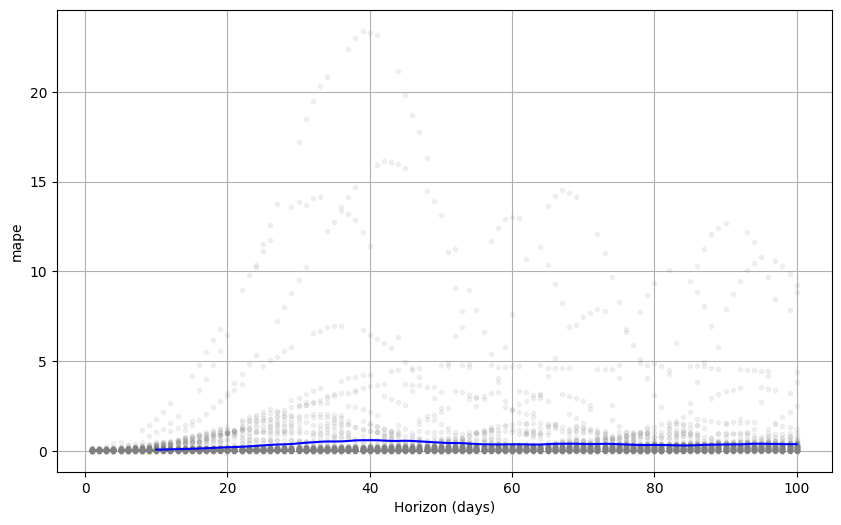

In [34]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')